# <center>Beam Orientation Optimization (BOO) </center>


IMRT beams are often hand-picked in a clinical setting by expert planners. The process of selecting an optimal set of beams gives rise to challenging large-scale non-convex optimization problems. Over time, numerous heuristic techniques have been developed to solve these optimization problems within a clinically feasible timeframe. A natural question that arises during the development of a new technique is: "how close are we to the globally optimal solution?". This example offers a benchmark global optimal solution to address this question.

Beam Orientation Optimization (BOO) can be formulated as a mixed integer programming problem (MIP) that can be solved to global optimality on small/medium problems. One could solve these computationally demanding MIP problems using down-sampled data or using a high-performance computing platform, when time pressure is not a consideration. The global optimal solution provided by MIP could then serve as a benchmark for validating and aiding the development of more computationally efficient strategies.

To construct the MIP problem, we first need to formulate a typical IMRT optimization problem (refer to [basic_tutorial](http://localhost:8888/notebooks/examples/1_basic_tutorial.ipynb)) that includes all the candidate beams. Next, we introduce a binary variable, $y_b$, which takes the value 1 if beam $b$ is selected and zero otherwise. We then impose a constraint to limit the number of selected beams. This can be achieved by adding the following constraints:

1- $\quad \mathbf{y}_b \in \{0,1\},~~\quad \mathbf{x}_{i,b} \leq \mathbf{y}_bM \quad \forall b \in B, \text{ and } \forall i \in I_b$.

Here, $B$ represents a set of candidate beams, $I_b$ is a set of beamlets belonging to beam $b$, and $M$ is a sufficiently large number. This constraint enforces that $y_b$ equals one if beam $b$ is selected (i.e., a beamlet within beam $b$ is positive).

2- $\quad \sum_{b \in B}\mathbf{y}_b \leq \mu$.

In this constraint, $\mu$ is the maximum number of beams permitted. This limits the number of beams selected.


### 1) Creating a plan using the manually selected beams 
 **Note**: If you're developing your own beam orientation optimization algorithm, it's important to compare your results with manually selected beams using full-resolution data. However, when you're benchmarking your algorithm against the global optimal solution provided by MIP, it's important to use downsampled data in both MIP and your algorithm for a fair comparison.
 
In this example, as we're comparing the results of MIP with manually selected beams, we apply downsampling to both scenarios.
The process of downsampling is explained in detail in a separate PortPy [down_sample](https://github.com/PortPy-Project/PortPy/blob/master/examples/advanced_tutorials/down_sampling.ipynb) tutorial. 


In [1]:
import sys
sys.path.append('..\..')

In [2]:
import portpy.photon as pp
import numpy as np
import os
import cvxpy as cp

In [3]:
# specify the patient data location.
data_dir = r'../../data'
# Use PortPy DataExplorer class to explore PortPy data
data = pp.DataExplorer(data_dir=data_dir)
# Pick a patient 
data.patient_id = 'Lung_Patient_6'
# Load ct, structure set, beams for the above patient using CT, Structures, and Beams classes
ct = pp.CT(data)
structs = pp.Structures(data)
beams = pp.Beams(data)
# Pick a protocol
protocol_name = 'Lung_2Gy_30Fx'
# Load clinical criteria for a specified protocol
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)
# Load hyper-parameter values for optimization problem for a specified protocol
opt_params = data.load_config_opt_params(protocol_name=protocol_name)
# Create optimization structures (i.e., Rinds) 
structs.create_opt_structures(opt_params=opt_params, clinical_criteria=clinical_criteria)
# Load influence matrix
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

# create a down-sampled influence matrix 
voxel_down_sample_factors = [6, 6, 1]
opt_vox_xyz_res_mm = [ct_res * factor for ct_res, factor in zip(ct.get_ct_res_xyz_mm(), voxel_down_sample_factors)]
beamlet_down_sample_factor = 4
new_beamlet_width_mm = beams.get_finest_beamlet_width() * beamlet_down_sample_factor
new_beamlet_height_mm = beams.get_finest_beamlet_height() * beamlet_down_sample_factor

inf_matrix_dbv = inf_matrix.create_down_sample(beamlet_width_mm=new_beamlet_width_mm,
                                               beamlet_height_mm=new_beamlet_height_mm,
                                               opt_vox_xyz_res_mm=opt_vox_xyz_res_mm)

# Create a plan using ct, structures, beams and influence matrix, and clinical criteria
plan_planner = pp.Plan(ct = ct, structs = structs, beams = beams, inf_matrix = inf_matrix_dbv, clinical_criteria=clinical_criteria)

# remove smoothness objective to have fair comparison
for i in range(len(opt_params['objective_functions'])):
    if opt_params['objective_functions'][i]['type'] == 'smoothness-quadratic':
        opt_params['objective_functions'][i]['weight'] = 0
    if opt_params['objective_functions'][i]['type'] == 'quadratic-overdose':
        opt_params['objective_functions'][i]['weight'] = 5000
    if opt_params['objective_functions'][i]['type'] == 'quadratic-underdose':
        opt_params['objective_functions'][i]['weight'] = 20000  
# Create cvxpy problem using the clinical criteria and optimization parameters
opt = pp.Optimization(plan_planner, opt_params=opt_params, clinical_criteria=clinical_criteria)
opt.create_cvxpy_problem()
# Solve the cvxpy problem using Mosek
sol_planner = opt.solve(solver='MOSEK', verbose=False)

creating rinds.. This step may take some time due to dilation
Optimization structures created!!
Creating BEV..
Loading sparse influence matrix...
Done
reindexing voxels...
parsing influence matrix for beam 0
parsing influence matrix for beam 1
parsing influence matrix for beam 2
parsing influence matrix for beam 3
parsing influence matrix for beam 4
parsing influence matrix for beam 5
parsing influence matrix for beam 6
creating influence matrix for down sample voxels..
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 52.51983751578567
Elapsed time: 16.364466190338135 seconds


### 2) Obtaining the benchmark global optimal solution
**Note**: We have chosen 7 beams from a relatively small pool of 24 potential candidates due to computational constraints associated with Mixed Integer Programming

In [4]:
# roughly select beam_ids around planner beams
beam_ids = list(np.arange(0, 72, 3))
beams_boo = pp.Beams(data, beam_ids=beam_ids)

# load the influence matrix
inf_matrix_boo = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams_boo)
# create a down-sampled influence matrix
voxel_down_sample_factors = [6, 6, 1]
opt_vox_xyz_res_mm = [ct_res * factor for ct_res, factor in zip(ct.get_ct_res_xyz_mm(), voxel_down_sample_factors)]
beamlet_down_sample_factor = 4
new_beamlet_width_mm = beams.get_finest_beamlet_width() * beamlet_down_sample_factor
new_beamlet_height_mm = beams.get_finest_beamlet_height() * beamlet_down_sample_factor

inf_matrix_boo_dbv = inf_matrix_boo.create_down_sample(beamlet_width_mm=new_beamlet_width_mm,
                                                       beamlet_height_mm=new_beamlet_height_mm,
                                                       opt_vox_xyz_res_mm=opt_vox_xyz_res_mm)
# create a plan
plan_boo = pp.Plan(ct=ct, structs=structs, beams=beams_boo, inf_matrix=inf_matrix_boo_dbv, clinical_criteria=clinical_criteria)
# create a cvxpy optimization instance
opt = pp.Optimization(plan_boo, opt_params=opt_params)
opt.create_cvxpy_problem()

# add binary variables and constraints for beam orientation optimization
b = cp.Variable(len(inf_matrix_boo_dbv.beamlets_dict), boolean=True)
num_beams = 7
x = opt.vars['x']

opt.constraints += [cp.sum(b) <= num_beams]
for i in range(len(inf_matrix_boo_dbv.beamlets_dict)):
    start_beamlet = inf_matrix_boo_dbv.beamlets_dict[i]['start_beamlet_idx']
    end_beamlet = inf_matrix_boo_dbv.beamlets_dict[i]['end_beamlet_idx']
    M = 50  # upper bound on the beamlet intensity
    opt.constraints += [x[start_beamlet:end_beamlet] <= b[i] * M]

Creating BEV..
Loading sparse influence matrix...
Done
reindexing voxels...
parsing influence matrix for beam 0
parsing influence matrix for beam 1
parsing influence matrix for beam 2
parsing influence matrix for beam 3
parsing influence matrix for beam 4
parsing influence matrix for beam 5
parsing influence matrix for beam 6
parsing influence matrix for beam 7
parsing influence matrix for beam 8
parsing influence matrix for beam 9
parsing influence matrix for beam 10
parsing influence matrix for beam 11
parsing influence matrix for beam 12
parsing influence matrix for beam 13
parsing influence matrix for beam 14
parsing influence matrix for beam 15
parsing influence matrix for beam 16
parsing influence matrix for beam 17
parsing influence matrix for beam 18
parsing influence matrix for beam 19
parsing influence matrix for beam 20
parsing influence matrix for beam 21
parsing influence matrix for beam 22
parsing influence matrix for beam 23
creating influence matrix for down sample voxe

In [13]:
# solve the problem    
sol_boo = opt.solve(solver='MOSEK', verbose=True)

Running Optimization..
Optimal value: 49.08229664930079
Elapsed time: 332216.5306146145 seconds


### 3) Comparing the plans obtained with manually/optimally selected beams 

In [7]:
# Identifying manually/optimally selected beam angles
boo_gantry_angles = (np.asarray(plan_boo.beams.beams_dict['gantry_angle']) + 1) * (b.value > 0)
boo_gantry_angles = boo_gantry_angles[boo_gantry_angles > 0] - 1  # add and subtract 1 to check for 0 degree angle
print('BOO gantry angles: {}'.format(boo_gantry_angles))
planner_gantry_angles = plan_planner.beams.beams_dict['gantry_angle']
print('Planner gantry angles: {}'.format(planner_gantry_angles))

BOO gantry angles: [  0  30  60 195 270 285 345]
Planner gantry angles: [0, 185, 210, 240, 270, 300, 330]


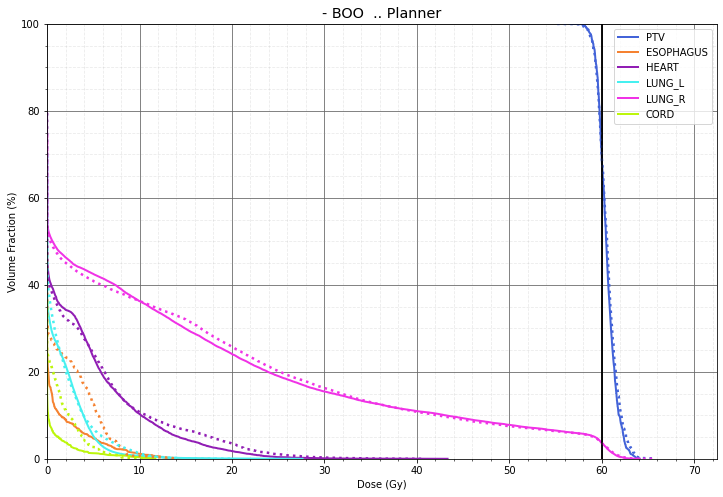

In [8]:
# plot dvh for both plans
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD', 'LUNG_L', 'LUNG_R']
ax = pp.Visualization.plot_dvh(plan_boo, sol=sol_boo, struct_names=struct_names, style='solid', ax=ax)
ax = pp.Visualization.plot_dvh(plan_planner, sol=sol_planner, struct_names=struct_names, style='dotted', ax=ax)
ax.set_title('- BOO  .. Planner')
plt.show()
